In [6]:
%matplotlib inline
%load_ext memory_profiler
import cProfile

from string import ascii_uppercase

import numpy as np
import pandas as pd

cols = list(ascii_uppercase[:10])
np.random.seed(42)


def crosstab(df):
    '''Returned count values are integers.'''
    pd.crosstab(df.A, df.B)


def groupby(df):
    '''Returned count values are floats.'''
    df.groupby(['A', 'B'])['C'].count().unstack().fillna(0)


def pivot_table(df):
    '''Returned count values are integers.'''
    df.pivot_table(values='C', index='A', columns='B', aggfunc='count', fill_value=0)

    
data = np.random.randint(1, 100, size=(100_000, 10))
df = pd.DataFrame(data, columns=cols)
df.head()

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


,A,B,C,D,E,F,G,H,I,J
0,52,93,15,72,61,21,83,87,75,75
1,88,24,3,22,53,2,88,30,38,2
2,64,60,21,33,76,58,22,89,49,91
3,59,42,92,60,80,15,62,62,47,62
4,51,55,64,3,51,7,21,73,39,18


In [160]:
%%timeit
crosstab(df)

81.6 ms ± 834 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%timeit
df.pivot_table(values='C', index='A', columns='B', aggfunc='count', fill_value=0)

33.3 ms ± 268 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%%timeit
pd.crosstab(df.A, df.B)

79.4 ms ± 891 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
def profile_call(func, *args, **kwargs):
    profile = cProfile.Profile()
    profile.enable()
    func(*args, **kwargs)
    profile.disable()
    stats = profile.getstats()
    df_profile = pd.DataFrame(stats, columns=['code', 'callcount', 'reccallcount', 'totaltime', 'inlinetime', 'calls'])
    df_profile.sort_values('totaltime', ascending=False, inplace=True)
    return df_profile

df_profile = profile_call(pd.crosstab, df.A, df.B)
df_profile.head()

In [12]:
df_profile = profile_call(df.pivot_table, values='C', index='A', columns='B', aggfunc='count', fill_value=0)
df_profile.head()

,code,callcount,reccallcount,totaltime,inlinetime,calls
342,"<code object pivot_table at 0x7fa3a0208f60, fi...",1,0,0.057103,0.000040,[(<code object _handle_fromlist at 0x7fa3e8a9e...
48,"<code object pivot_table at 0x7fa39f8d7a50, fi...",1,0,0.057060,0.000117,"[(<code object dropna at 0x7fa3a0208270, file ..."
150,"<code object apply at 0x7fa39ffb2300, file ""/h...",6,0,0.032086,0.000060,"[(<code object fillna at 0x7fa39ffffb70, file ..."
339,"<code object fillna at 0x7fa3a0203ae0, file ""/...",1,0,0.031380,0.000005,"[(<code object fillna at 0x7fa3a00ff780, file ..."
325,"<code object fillna at 0x7fa3a00ff780, file ""/...",1,0,0.031375,0.000018,"[(<code object fillna at 0x7fa39ffb2ae0, file ..."


In [24]:
timeit.timeit('''df.groupby(['A', 'B'])['C'].count().unstack().fillna(0)''', number=1, globals=globals())

0.011541660998773295

In [2]:
import timeit

from collections import defaultdict
from memory_profiler import memory_usage

funcs = [crosstab, groupby, pivot_table]
samples = []

#for size in np.logspace(3, 7, 5):
for size in np.logspace(3, 5, 2):
    size = int(size)
    repetitions = 1
    
    data = np.random.randint(1, 100, size=(size, 10))
    df = pd.DataFrame(data, columns=cols)
    
    for func in funcs:
        duration = timeit.timeit('func(df)', number=repetitions, globals=globals()) / repetitions
        memory = np.mean(memory_usage(proc=(func, (df,))))
        samples.append({'function': func.__name__, 'size': size, 'duration': duration, 'memory': memory})

In [5]:
df_samples = pd.DataFrame(samples)
df_samples['function'] = df_samples.function.astype('category')

axes = df_samples.plot(subplots=True, sharex=True, kind='line')
axes[1].set_xticklabels(df_samples.index);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0d8246d30>],
      dtype=object)

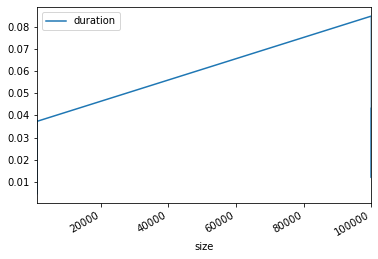

In [181]:
df_samples.plot('size', 'duration', subplots=True)

In [3]:
grouped_samples = df_samples.groupby(['size', 'function']).agg(np.mean)
grouped_samples.head()

NameError: name 'df_samples' is not defined

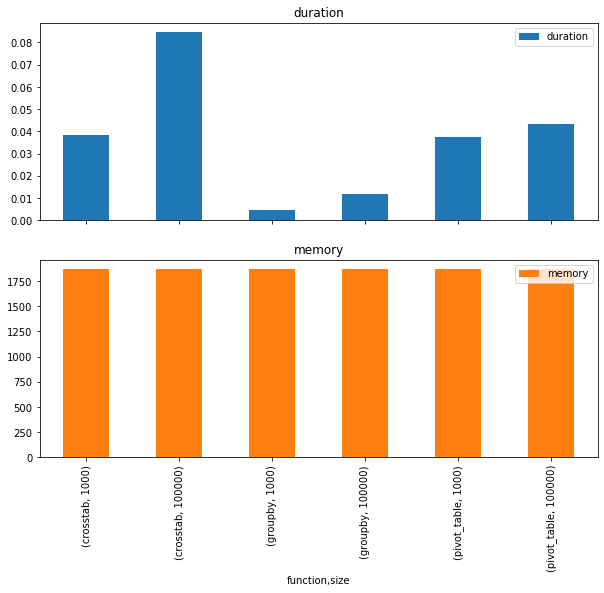

In [201]:
grouped_samples.plot(figsize=(10, 8), kind='bar', subplots=True);